# Perceptron with Pytorch
#### Luca Laringe

In this notebook, I will show a basic implementation of a perceptron using Pytorch.
A perceptron is a single layer neural network, it is maily used for classification purposes. More info at https://en.wikipedia.org/wiki/Perceptron.

## Data

In this section I am going to generate the data we are going to fit my model on. Let's first import the libraries we need.

In [150]:
import torch                                         # Our main library         
import torch.nn as nn                                # To define a neural network
from torch.utils.data import Dataset, DataLoader     # To put the data in a class that pytorch knows hoe to handle
from torch.distributions import multivariate_normal  # To generate random data
import pandas as pd
import sklearn                                       # To fit a logit regression for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report    # Accuracy metrics 
from sklearn.metrics import accuracy_score           

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(14, 8))
plt.rc('grid', color='gray', alpha = 0.3, linestyle='solid')

from IPython.core.debugger import set_trace           # Debugging tool

Let's now generate some data coming from two clusters (I call them $cluster_0$ and $cluser_1$). Each cluster is going to be distributed as a bivariate normal with its own mean vector and covariance matrix.

In [151]:
n_sample_0 = 100
n_sample_1 = 100
n_sample = n_sample_0 + n_sample_1

mean_0 = torch.Tensor([0.3,0.7])  # Mean vector of cluster 0
mean_1 = torch.Tensor([0.7,0.3])  # Mean vector of cluster 1
cov_0 = 0.005*torch.eye(2)        # Covariance matrix of cluster 0
cov_1 = 0.005*torch.eye(2)        # Covariance matrix of cluster 1

cluster_0_dist = multivariate_normal.MultivariateNormal(loc=mean_0, covariance_matrix=cov_0)
cluster_1_dist = multivariate_normal.MultivariateNormal(loc=mean_1, covariance_matrix=cov_1)

data_cluster_0 = cluster_0_dist.sample((n_sample_0,))                     # Sample the features
data_cluster_0 = torch.cat((data_cluster_0, torch.zeros(n_sample_0,1)),1) # Generate the labels

data_cluster_1 = cluster_1_dist.sample((n_sample_1,))                     # Sample the features
data_cluster_1 = torch.cat((data_cluster_1, torch.ones(n_sample_1,1)),1)  # Generate the labels

# Aggregate the data by rows, shuffle them and then divide them into training and testing
data = torch.cat((data_cluster_0, data_cluster_1),0)
data = data[torch.randperm(n_sample).numpy(),:]

data_train = data[:int(n_sample*0.7)]
data_test = data[int(n_sample*0.7):]

In [152]:
# Check everything worked out as expected

print(len(data) == len(data_train) + len(data_test), len(data))
print(data[:10])

True 200
tensor([[ 0.7518,  0.4163,  1.0000],
        [ 0.4189,  0.7279,  0.0000],
        [ 0.7174,  0.3219,  1.0000],
        [ 0.2722,  0.7001,  0.0000],
        [ 0.3235,  0.7625,  0.0000],
        [ 0.2451,  0.6859,  0.0000],
        [ 0.7806,  0.2567,  1.0000],
        [ 0.7306,  0.3251,  1.0000],
        [ 0.3414,  0.7352,  0.0000],
        [ 0.2486,  0.7250,  0.0000]])


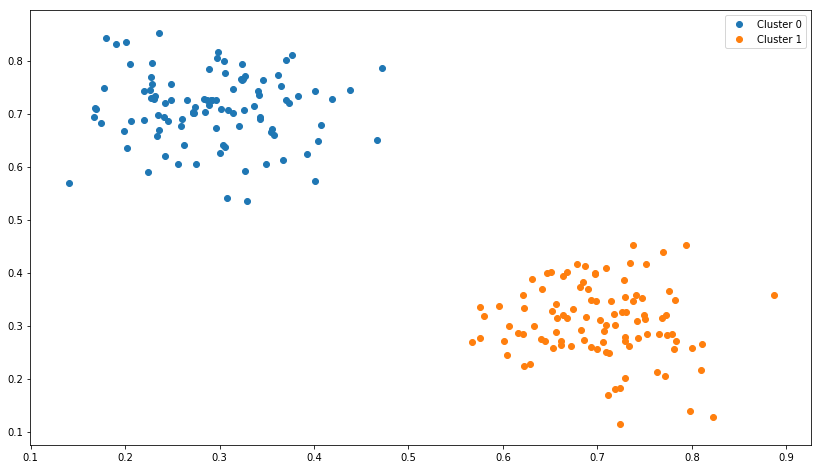

In [153]:
# Visualizing the data

plt.scatter(data_cluster_0[:,0], data_cluster_0[:,1]);
plt.scatter(data_cluster_1[:,0], data_cluster_1[:,1]);
plt.legend(['Cluster 0', 'Cluster 1']);

Now that we have our data, let's create a dataset and a dataloader so we can use batches to train the model.

First we will create the my_dataset class that inherits from the Dataset class in Pytorch. We need to do it in order to use the Dataloader later. In every dataset class you build, you should always specify the \__init__ method recalling that your class should call the \__init__ method of the superclass, the \__len__ method which returns the length of the dataset, and finally the 
\__getitem__ method , that takes an index and returns the features and labels of the dataset at that index. Note that we are not going to use the transform function here because our data is already tidy and organized in a Pytorch tensor. Nevertheless, when your data is stored in another data structure, for example a pandas DataFrame, the transform function should be viewed as a bridge between your data structure and a Pytorch tensor.

Finally, the Dataloader function will allow us to divide the training set in batches, so that our training will be more effective. In partucular, for each epoch of training, I will divide my training set in 5 batches.

In [154]:
class my_dataset(Dataset):
    
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        features = data[index,:2]
        labels = data[index, 2]
        
        if self.transform:
            features = self.transform(features)
            labels = self.transform(labels)
            
        return (features.reshape(2), labels.reshape(1))
    
# Define instances of my_dataset
my_data_train = my_dataset(data_train)
my_data_test = my_dataset(data_test)

# Define the data loader for the traning data
n_batches = 5

train_loader = DataLoader(batch_size=int(len(my_data_train)/n_batches),
                          dataset=my_data_train, shuffle=True)

In [155]:
# Check everything works as expected
print(my_data_train.__getitem__(0)[0])
print(my_data_train.__getitem__(0)[1])

tensor([ 0.7518,  0.4163])
tensor([ 1.])


## Modelling

Let's now define a perceptron. 

Note that in Pytorch, every neural network you design, should inherit from the superclass nn.Module. Note also that I will built my perceptron to have a continuous output. To do so I will use the logistic function as the activation function of the output neuron. Doing so, will allow me to interpret the output of the perceptron as the probability of the data point to belong to cluster 1. If you would like a binary output, in general will have to use the unit step activation function.

In [156]:
class perceptron(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features
        self.fc1 = nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = torch.sigmoid(out)
        return(out)

Now that we defined our perceptron class, we need to optimize the network. In order to do so, we will need 3 things (you will always need these regardless of the neural network model you are using):

* An *instance* of the model: in our case, we are going to call the perceptron class and initialize it to have 2 features (like our dataset).
* A loss function to optimize: I will call it criterion and I will use the MSE loss. I am not using the perceptron loss function because I have a continuous output.
* An optimizer: In this case, I will use stochastic gradient descent.

In [157]:
# Define an instance of such network
my_perceptron = perceptron(2)

# Define a loss
criterion = nn.MSELoss()

# Define an optimizer
optimizer = optimizer = torch.optim.SGD(my_perceptron.parameters(), lr=0.01) 

In [158]:
# Check everything works as expected

print(my_perceptron(torch.Tensor([0.3,0.7])))
print(my_perceptron(my_data_train.__getitem__(0)[0]))

print(criterion(torch.zeros(1), torch.zeros(1)))
print(criterion(torch.zeros(1), torch.ones(1)))

print(my_data_train.__getitem__(0)[1].shape)
print(my_perceptron(my_data_train.__getitem__(0)[0]).shape)

my_data_train.__getitem__(0)[0]
my_data_train.__getitem__(0)[1]

tensor([ 0.6066])
tensor([ 0.5980])
tensor(0.)
tensor(1.)
torch.Size([1])
torch.Size([1])


tensor([ 1.])

## Training

In [159]:
n_epochs = 1000

for epoch in range(1,n_epochs+1):
    
    loss_training = 0
    
    for i, (x, y) in enumerate(train_loader):
        
        my_perceptron.train()        # Set the model in training mode
        optimizer.zero_grad()        # Set the grazient to 0
        y_ = my_perceptron(x)        # Compute the predicted values
        loss = criterion(y_, y)      # Compute the loss
        loss.backward()              # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step()             # Updates the parameters
        
        loss_training += loss.data.numpy()/n_batches # Averages up loss for each batch of training
        
    if ((epoch == 1) or (epoch%(n_epochs//5) == 0)):
        
        my_perceptron.eval()         # Set the model in evaluation mode
        
        test_features = data_test[:,:2]
        test_labels = data_test[:,2].reshape(len(data_test),1)
        test_predictions = my_perceptron(test_features) 
        
        loss_test = criterion(test_predictions, test_labels)  # Computing (average) loss on test set
        
        print('Epoch n. %d, Training Loss: %.4f, Test Loss: %.4f'
             %(epoch, loss_training, loss_test.data.numpy()))

Epoch n. 1, Training Loss: 0.2719, Test Loss: 0.2756
Epoch n. 200, Training Loss: 0.2166, Test Loss: 0.2172
Epoch n. 400, Training Loss: 0.1776, Test Loss: 0.1782
Epoch n. 600, Training Loss: 0.1477, Test Loss: 0.1486
Epoch n. 800, Training Loss: 0.1248, Test Loss: 0.1260
Epoch n. 1000, Training Loss: 0.1071, Test Loss: 0.1085


## Model Evaluation

Let's evaluate the performance of our model computing the accuracy of the predictions on the test set and visializing the decision boundary the perceptron learned.

In [160]:
# Now let's compute the predictions and plot them

y_ = my_perceptron(data_test[:,:2]) > 0.5               # Assigns one if the value is greater than 0.5
y_test_ = y_.numpy().transpose()[0]
y_test = data_test[:,2].numpy()

print(classification_report(y_test, y_test_))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        31
        1.0       1.00      1.00      1.00        29

avg / total       1.00      1.00      1.00        60



In [161]:
a = accuracy_score(y_test, y_test_)
print('Accuracy score on test set: ','{:.2%}'.format(a))

Accuracy score on test set:  100.00%


Let's now try to visualize the decision boundary. To do so I will bo through some basic math.
Our perceptron takes two inputs: $x_1$ and $x_2$ and outputs a value between 0 and 1. If such value is greater than 0.5, we predict 1, else we predict 0.

The output value is given by:

$ output = sigmoid ( bias + weight_1 \times x_1 + weight_2 \times x_2)$

The boundary satisfies this condition:

$ sigmoid(bias + weight_1 \times x_1 + weight_2 \times x_2) = 0.5 $

Hence, we can solve for $x_2$ and find the equation of the line:

$ x_2 = \frac{sigmoid^{-1}(0.5)-bias}{weight_2} - \frac{weight_1}{weight_2} \times x_1 $

Also, note that the sigmoid function is:

$sigmoid(z) = \frac{1}{1+e^{-z}}$

And thus its inverse is:

$sigmoid^{-1}(x) = -\log(\frac{1-x}{x}) = \log(\frac{x}{1-x})$

Now we are ready to plot!

In [162]:
def sigmoid_inv(x):
    return np.log(x/(1-x))

bias = my_perceptron.fc1.bias.detach().numpy()[0]
weight_1 = my_perceptron.fc1.weight.detach().numpy()[0][0]
weight_2 = my_perceptron.fc1.weight.detach().numpy()[0][1]

Let's first visualize the decision boundary and the test set.

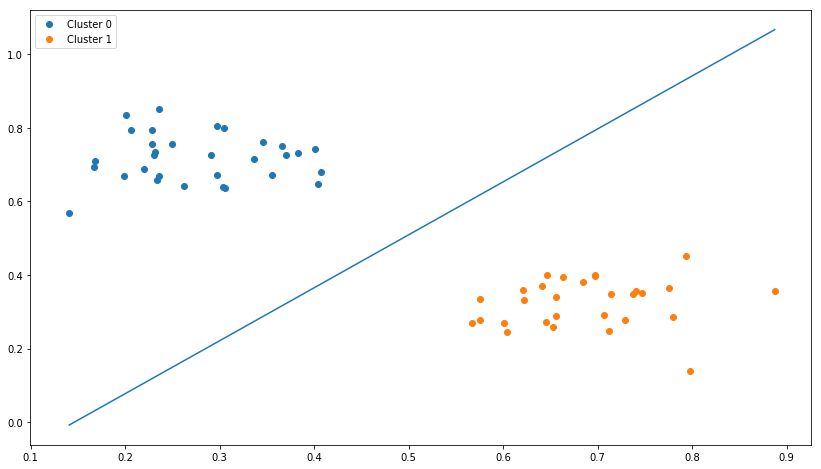

In [163]:
xs = np.linspace(torch.min(data_test[:,0]), torch.max(data_test[:,0]),1000)
ys = (sigmoid_inv(0.5)-bias)/weight_2 - (weight_1/weight_2)*xs

data_test_0 = data_test[data_test[:,2] == 0]
data_test_1 = data_test[data_test[:,2] == 1]

plt.scatter(data_test_0[:,0], data_test_0[:,1]);
plt.scatter(data_test_1[:,0], data_test_1[:,1]);
plt.legend(['Cluster 0', 'Cluster 1']);
plt.plot(xs,ys);

Let's now look at the same chart for all our data.

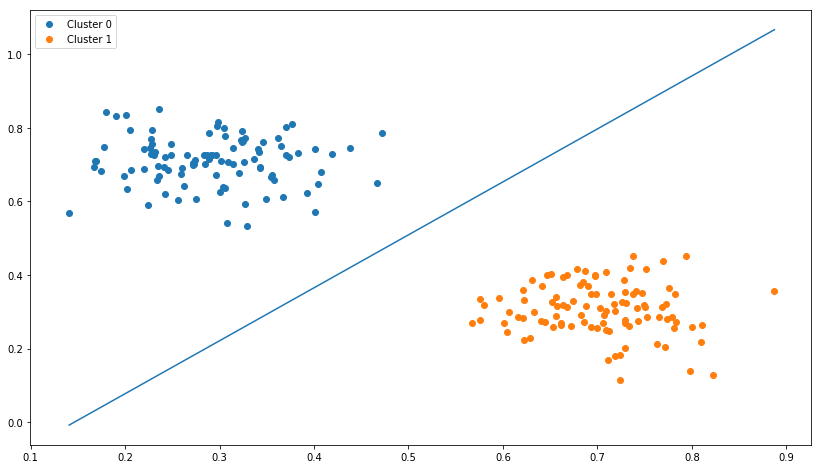

In [164]:
plt.scatter(data_cluster_0[:,0], data_cluster_0[:,1]);
plt.scatter(data_cluster_1[:,0], data_cluster_1[:,1]);
plt.legend(['Cluster 0', 'Cluster 1']);
plt.plot(xs,ys);

## Logistic Regression Comparison

In this final section, I am going to compare the Perceptron with a simple logistic regression. As I already showed, the output of the perceptron is given by:

$output=sigmoid(bias+weight1×x1+weight2×x2))$

A basic logistic regression yields the same output. Hence we can state that the perceptron is a logistic regression at its core. The two predictive models are nonetheless different due to how they are trained (or estimated, in case of the logit regression). As we have seen, the percetron uses a stochastic gradient descent in order to incrementally update the weights during training. On the other hand, the logistic regression' weights are usually estimated estimated by means of log likelihood maximization (usually l1, l2 ot both penalizations are added to the objective function). The logit regression algorithm builds upon some statistical assumptions about the underlying' data distribution and then selects its weights so that the likelihood of observing the training data under the model is maximum. 

Let's now fit a logit regression to our data, assess its perfomance and compare the its decision boundary with the perceptron'.

In [165]:
# First, let's prepare the data to make them sklearn friendly

In [166]:
d = pd.DataFrame(data_train.numpy()).iloc[:,:2]

x_train = data_train.numpy()[:,:2]
y_train = data_train.numpy()[:,2]

x_test = data_test.numpy()[:,:2]
y_test = data_test.numpy()[:,2]

In [167]:
my_log_reg = LogisticRegression()               # Define an istance of the LogistcRegression sklearn class
my_log_reg.fit(x_train,y_train)                 # Fit the logit regression defined before

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [168]:
# Now let's compute the classification measures and the accuracy score on the test set 
y_test_ = my_log_reg.predict(x_test)
f = classification_report(y_test, y_test_)
print(f)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        31
        1.0       1.00      1.00      1.00        29

avg / total       1.00      1.00      1.00        60



In [169]:
a = accuracy_score(y_test, y_test_)
print('Accuracy score on test set: ','{:.2%}'.format(a))

Accuracy score on test set:  100.00%


As the perceptron, the logit regression achieved 100% accuracy on the test set. Finally, let's compare the decision boundaries. As for the perceptron, the logit regression decision boundary is given by:

$ x_2 = \frac{sigmoid^{-1}(0.5)-bias}{weight_2} - \frac{weight_1}{weight_2} \times x_1 $

In [170]:
bias_logit = float(my_log_reg.intercept_)
weight_1_logit =  float(my_log_reg.coef_[0,0])
weight_2_logit = float(my_log_reg.coef_[0,1])

In [171]:
ys_logit = (sigmoid_inv(0.5)-bias_logit)/weight_2_logit - (weight_1_logit/weight_2_logit)*xs

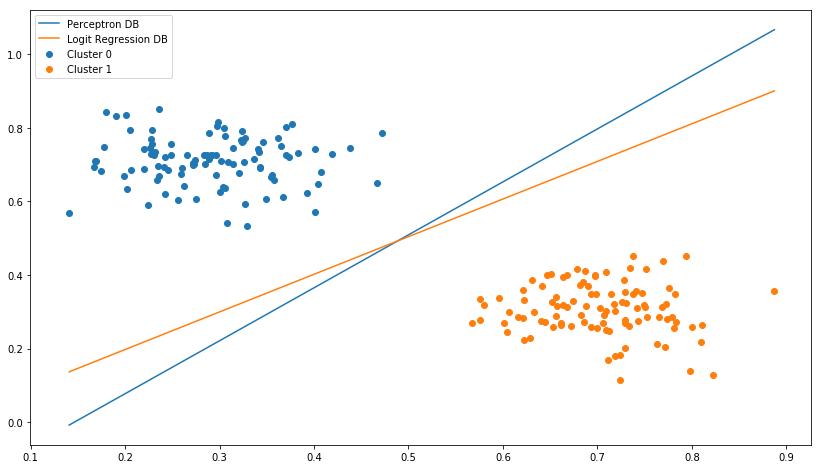

In [172]:
# Plot the whole dataset and the decision boundaries (DBs)

plt.scatter(data_cluster_0[:,0], data_cluster_0[:,1]);
plt.scatter(data_cluster_1[:,0], data_cluster_1[:,1]);
plt.plot(xs,ys);
plt.plot(xs,ys_logit);
plt.legend(['Perceptron DB', 'Logit Regression DB','Cluster 0', 'Cluster 1']);